# Analyzing the Predictability of European Football Leagues

## Introduction
Over the past few decades football has been criticsed for being too predictable. The elite clubs in europe continue to increase their revenues year after year and thus can spend small fortunes on lesser clubs' best players. This is perhaps most apparent in Germany where Bayern Munich have a monopoly-like claim on any young promising German player. The result has been 7 winners medals in the past decade.

However, the 2015/2016 season has had many unexpected outcomes in soccer. Leicster, having finished the previous season in 14th place went on to win the English Premier league at 5000/1 odds. Similarly, in Euro 2016 Iceland, a country with a population of only 300,000, beat England in the knockout stages and Wales made it all the way to the semi-finals.

This notebook will attempt to quantify the top 5 European league's predictability by utilizing bookmakers odds for each match. The idea is that if there are consistently large favourites in games throughout the season then the league is considered predictable. The goal here is to find the most unpredictable league which should then also be the most competitive and interesting one to watch.

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np

from numpy import random
from scipy.stats import entropy
from matplotlib.lines import Line2D
from matplotlib import rcParams

sns.set(style="whitegrid")
%matplotlib inline

C:\Users\Chris\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Custom plot parameters

In [2]:
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['axes.grid'] = True

## Loading the data
The data used in this notebook is taken from Kaggle’s European Soccer database, which spans across 8 years from 2008 to 2016 and includes many teams and matches statistics. A codebook for the variables can be found [here](http://football-data.co.uk/notes.txt).

In [3]:
# Load data using SQL.
with sqlite3.connect('../Data/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)

In [4]:
countries.head(2)

,id,name
0,1,Belgium
1,1729,England


In [5]:
matches.head(2)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.2
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6


In [6]:
leagues.head(2)

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League


In [7]:
teams.head(2)

,id,team_api_id,team_long_name,team_short_name
0,1,9987,Genk,GEN
1,2,9993,Beerschot AC,BAC


## Data wrangling

In [8]:
# Subset on relevant countries.
selected_countries = ['England', 'France', 'Germany', 'Italy', 'Spain']
countries = countries[countries.name.isin(selected_countries)]

countries

,id,name
1,1729,England
2,4735,France
3,7775,Germany
4,10223,Italy
9,21484,Spain


In [9]:
# Merge countries and leagues.
leagues = countries.merge(leagues, on='id', suffixes=('', '_y'))

leagues

,id,name,country_id,name_y
0,1729,England,1729,England Premier League
1,4735,France,4735,France Ligue 1
2,7775,Germany,7775,Germany 1. Bundesliga
3,10223,Italy,10223,Italy Serie A
4,21484,Spain,21484,Spain LIGA BBVA


In [10]:
# Subset matches on relevant leagues.
matches = matches[matches.league_id.isin(leagues.id)]

In [11]:
# Checking all columns.
matches.columns.values

array(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_X1',
       'home_player_X2', 'home_player_X3', 'home_player_X4',
       'home_player_X5', 'home_player_X6', 'home_player_X7',
       'home_player_X8', 'home_player_X9', 'home_player_X10',
       'home_player_X11', 'away_player_X1', 'away_player_X2',
       'away_player_X3', 'away_player_X4', 'away_player_X5',
       'away_player_X6', 'away_player_X7', 'away_player_X8',
       'away_player_X9', 'away_player_X10', 'away_player_X11',
       'home_player_Y1', 'home_player_Y2', 'home_player_Y3',
       'home_player_Y4', 'home_player_Y5', 'home_player_Y6',
       'home_player_Y7', 'home_player_Y8', 'home_player_Y9',
       'home_player_Y10', 'home_player_Y11', 'away_player_Y1',
       'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y5', 'away_player_Y6', 'away_player_Y7',
       'aw

This notebook uses bet365 as the booker whos odds are used in calculations. These probabilities should reflect the objective chance for each game outcome.

In [12]:
# Subset on releveant fields.
matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 
                   'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]

# Drop any null rows.
matches.dropna(inplace=True)

matches.head(2)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1.29,5.5,11.00
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,5.50,3.6,1.67


## Entropy
In Information Theory, [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory) is a measurement for uncertainty for an event’s outcome. In this case, the event is a football match and there are three possible outcomes: a win for the home team, a win for the away team or a draw. If the three outcomes are equally probable, the uncertainty is maximal and so is the entropy (log(3)=1.584963). As the probability of a particular outcome will get closer to one - almost no uncertainty - the match entropy will approach zero. In summary, the entropy of a football game outcome is bounded by 0 and 1.59, where 0 is total predictability.


In [13]:
def match_entropy(row):
    """
    Takes a row from the matches df, transforms the odds into normalized
    probabilities. Returns the entropy of these probabilities.
    """

    # Select the odds for home, draw, away.
    odds = [row['B365H'], row['B365D'], row['B365A']]

    # Take the inverse to change decimal odds to probability.
    probs = [1/o for o in odds]

    # Get the sum of probabilities.
    norm = sum(probs)

    # Normalize the probalities.
    # (Accounts for bookies using "overround").
    probs = [p/norm for p in probs]

    # Take the entropy of the normalized probabilities.
    result = entropy(probs)
    
    return result

In [14]:
# Compute entropy for every match
matches['entropy'] = matches.apply(match_entropy, axis=1)

In [15]:
matches.head(2)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A,entropy
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1.29,5.5,11.00,0.738980
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,5.50,3.6,1.67,0.975928


In [16]:
# Compute mean entropy for every league for every season.
entropy_means = matches.groupby(('league_id', 'season')).entropy.mean()

In [17]:
# Transpose the table so that season is the index.
entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')

# Change league id to its name.
entropy_means.columns = [leagues[leagues.id==x].name.values[0] for x in entropy_means.columns]

entropy_means

,England,France,Germany,Italy,Spain
season,,,,,
2008/2009,0.985462,1.026528,1.004476,1.002100,1.010734
2009/2010,0.956445,1.013726,0.997749,1.006562,0.978531
2010/2011,0.983073,1.026196,1.016482,1.006734,0.974721
2011/2012,0.970060,1.024725,1.001488,1.003185,0.954997
2012/2013,0.981854,1.016093,0.994724,1.003405,0.970283
2013/2014,0.960774,1.004431,0.978929,0.992938,0.944064
2014/2015,0.981162,1.013026,0.986681,0.999356,0.933217
2015/2016,0.997686,1.014130,0.976424,0.985519,0.946479


In [18]:
entropy_means.mean()

England    0.977064
France     1.017357
Germany    0.994619
Italy      0.999975
Spain      0.964128
dtype: float64

## Visualizations

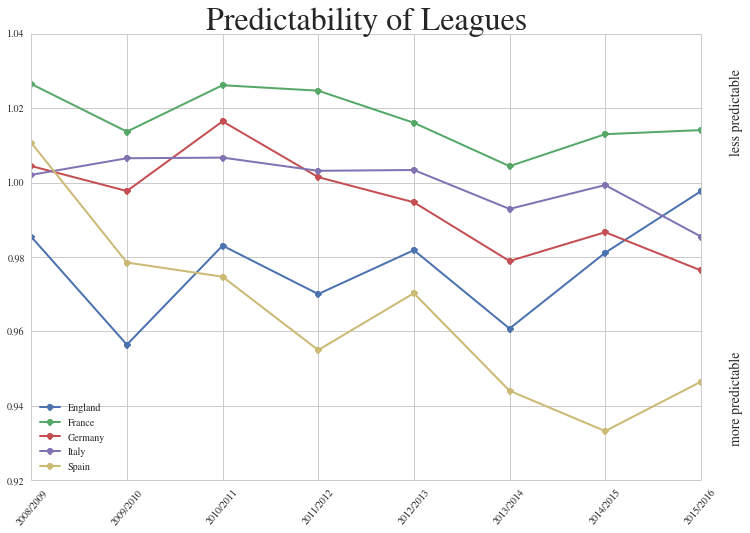

In [19]:
# Plot scatterplot.
ax = entropy_means.plot(figsize=(12,8), marker='o')

# Set title.
plt.title('Predictability of Leagues', fontsize=32)

# Set ticks roatation.
plt.xticks(rotation=50)

# Store color-league map for next graph.
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(leagues.id, colors))

# Remove x label.
ax.set_xlabel('')

# Locate legend.
plt.legend(loc='lower left')

# Add arrows.
ax.annotate('', xytext=(7.2, 1),xy=(7.2, 1.039),
            arrowprops=dict(facecolor='black', arrowstyle="->, head_length=.7, head_width=.3", 
                            linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.2, 0.96),xy=(7.2, 0.921),
            arrowprops=dict(facecolor='black', arrowstyle="->, head_length=.7, head_width=.3",
                            linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False, fontsize=14, rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False, fontsize=14, rotation='vertical')

The Spanish league has been the most predictable league for the past 6 seasons. This trend looks likely to continue as the Spanish, Italian, French and German leagues are all trending downwards. The English league on the other hand has gone from the 2nd most predictable to the 2nd least predictable within the space of just two seasons. To better understand these patterns, it is neccessary to drill down into the entropy of individual teams.

In [20]:
# Initialize arrays for df cols.
season_col = []
league_col = []
team_col = []
entropy_col = []

# Aggregate the matches by season.
for season, season_df in matches.groupby('season'):

    # For each team, get every match in which it is the home or away team.
    for team_id, team_name in zip(teams.team_api_id, teams.team_long_name):
        team_df = season_df[(season_df.home_team_api_id==team_id) | (season_df.away_team_api_id==team_id)]
        
        # Skip if the team isn't in the df for the 5 leagues.
        if team_df.empty:
            continue
            
        # Get the mean of entropy of the games that team was in.
        team_entropy = team_df.entropy.mean()
        
        # Get the league name.
        league_id = team_df.league_id.values[0]
        league_name = leagues[leagues.id == league_id].name.values[0]
        
        # Add values to the df cols.
        season_col.append(season)
        league_col.append(league_name)
        team_col.append(team_name)
        entropy_col.append(team_entropy)

In [21]:
# Create the dataframe.
data = {'Season': season_col,
        'League': league_col,
        'Team': team_col,
        'Entropy': entropy_col}

df = pd.DataFrame(data, columns=['Season', 'League', 'Team', 'Entropy'])
df.head(3)

,Season,League,Team,Entropy
0,2008/2009,England,Manchester United,0.843126
1,2008/2009,England,Newcastle United,1.014772
2,2008/2009,England,Arsenal,0.936522


In [22]:
# Lists of unique seasons and leagues.
seasons_list = df.Season.unique()
leagues_list = df.League.unique()

# Offsets for x coords, centered on season line.
offsets = [-0.2,-0.1,0,0.1,0.2]

# Dicts to map out x coords.
seasons_dict = dict(zip(seasons_list, range(len(seasons_list))))
leagues_dict = dict(zip(leagues_list, offsets))

In [23]:
def makeXCoord(row):
    """
    Takes in row and determines the X coordinate based on season and league.
    """
    
    # Get the X values for the season and league.
    season = seasons_dict[row.Season]
    offset = leagues_dict[row.League]
    
    # Add the values.
    X = season + offset
    
    return X

In [24]:
def makeColour(row):
    """
    Takes in row and determines the colour from the past plot.
    """
    
    # Get the league name and then the league id.
    league_name = row.League
    league_id = leagues[leagues.name == league_name].id.unique()[0]

    # Look up the colour dict.
    color = colors_mapping[league_id]

    return color

In [25]:
df['X'] = df.apply(makeXCoord, axis=1)
df['Colour'] = df.apply(makeColour, axis=1)

In [26]:
df.head(3)

,Season,League,Team,Entropy,X,Colour
0,2008/2009,England,Manchester United,0.843126,-0.2,"(0.298039215686, 0.447058823529, 0.690196078431)"
1,2008/2009,England,Newcastle United,1.014772,-0.2,"(0.298039215686, 0.447058823529, 0.690196078431)"
2,2008/2009,England,Arsenal,0.936522,-0.2,"(0.298039215686, 0.447058823529, 0.690196078431)"


C:\Users\Chris\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


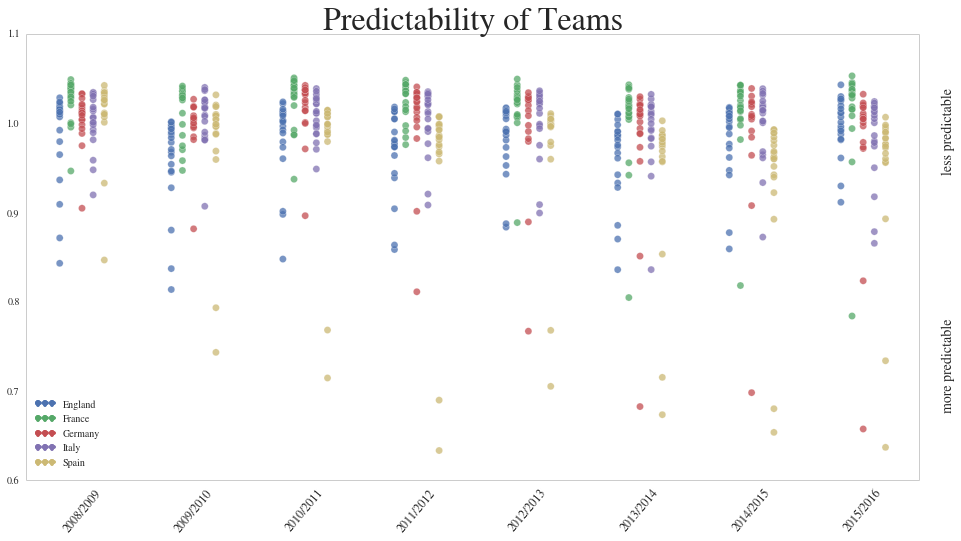

In [27]:
# Plot scatterplot.
plt.figure(figsize=(16, 8))
plt.scatter(df.X, df.Entropy, c=list(df.Colour), s=50, alpha=.75)
plt.title('Predictability of Teams', fontsize=32)

# Create ticks and labels.
ax = plt.gca()
plt.xlim((-0.5, 7.5))
plt.xticks(np.arange(0,8,1), rotation=50)

# Create grid.
ax.set_xticklabels(seasons_list, fontsize=12)

# Create dashline to separate seasons.
for i in range(7):
    ax.axvline(x=0.5+i, ls='--', c='w')

# Turn off grids.
ax.yaxis.grid(False)
ax.xaxis.grid(False)

# Create legend.
circles = []
labels = []
for league_id, name in zip(leagues.id, leagues.name):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=7, markerfacecolor=colors_mapping[league_id]))
plt.legend(circles, labels, numpoints=3, loc=(0.005,0.02))

# Add arrows.
ax.annotate('', xytext=(7.6, 0.92), xy=(7.6, 1.05),
            arrowprops=dict(facecolor='black', arrowstyle="->, head_length=.7, head_width=.3", 
                            linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.6, 0.78),xy=(7.6, 0.65),
            arrowprops=dict(facecolor='black', arrowstyle="->, head_length=.7, head_width=.3",
                            linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.7, 1.028), annotation_clip=False, fontsize=14, rotation='vertical')
ax.annotate('more predictable', xy=(7.7, 0.770), annotation_clip=False, fontsize=14, rotation='vertical')

Looking at the English teams, for the first four seasons there were a group of three or four teams with more entropy than the others. This separation soon became less and less as seasons passed.

On the other hand Spain has always had two teams distinct from the others. These two are most likely Barcelona and Real Madrid who have had a monopoly-like effect on the league. Similarly Germany has always had one team in front, with a second team nearby, and the rest lagging way behind. It would make sense for these two teams to be Bayern Munich and Borussia Dortmund respectively.

In order to verify these claims and make a more compelling graph I will recreate this plot in d3.

Aston villa was the 3rd most predicatble team in the premiership. Leicster was the least!

## Exporting the data

In [28]:
df.to_csv('../Data/teams_entropy.csv')

In [29]:
entropy_means.to_csv('../Data/leagues_entropy.csv')